# A tutorial for 

# *PersLay: A Simple and Versatile Neural Network Layer for Persistence Diagrams*. 

__Note:__ This is an alpha version of PersLay. Do not hesitate to contact the authors for any comment, suggestion, bug, etc.

# Introduction

Printing the current version of Python.

In [1]:
import sys
print("Current version of your system: (we recommand Python 3.6)")
print(sys.version)

Current version of your system: (we recommand Python 3.6)
3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


## Imports

In [2]:
from utils import generate, visualization, load
from archi import perslay, baseModel
from preprocessing import preprocess
from expe import single_run

## Outline:
In this notebook:
- First, we select a dataset. Two types of datasets are provided by default, either synthetic orbits from dynamical systems, or real-life graph dataset. 
- Then, we generate the persistence diagrams (and other useful informations such as labels, etc.) for the chosen dataset.
- (Optional) we propose to visualize the generated diagrams.
- We define a neural network that uses some PersLay channels as first layers to handle persistence diagrams. This can be used as a guideline to use PersLay in your own experiments.
- We show how to train this neural network on the chosen dataset.
- Finally, we explain how you could use PersLay with your own persistence diagrams

# 1. Building diagrams and eventual features from a provided dataset

We start by choosing the dataset we want to run the experiments on.

We suggest the user to start with `"MUTAG"` as this dataset is reasonably small (188 graphs with 18 nodes on average). Note that its small size implies a large variability in tests.

Available options are:

- Orbit datasets: `"ORBIT5K"`, `"ORBIT100K"`.

- Graphs datasets: `"MUTAG"`, `"BZR"`, `"COX2"`, `"DHFR"`, `"PROTEINS"`, `"NCI1"`, `"NCI109"`, `"FRANKENSTEIN"`,  `"IMDB-BINARY"`, `"IMDB-MULTI"`.

__Important note:__ `COLLAB`, `"REDDIT5K"` and `"REDDIT12K"` are not available yet (see README.md). Contact the authors for more information.

Beware that for the larger datasets (`COLLAB`, `REDDIT5K, REDDIT12K, ORBIT100K`), the needed files can be quite large (e.g. 3Gb for for `ORBIT100K`), so that RAM can be limiting, and time to generate the diagrams and running the experiments can be quite involving depending on the hardware available. You can have access to a description of the dataset in the Section B in the supplementary material of the article.

In [3]:
# Chose your config file using one of the filename mentioned above.
dataset = "MUTAG"

Here, we implicitely load our data (saved as `.mat` files for graphs datasets, and generated on-the-fly for orbits datasets---which can take some time for `ORBIT100K` especially), and then compute the persistence diagrams that will be used in the classification experiment (requires to have `gudhi` installed). For graph datasets, we also generate a series of additional features (see [1]).

Running `generate` will store diagrams, features and labels. Therefore, it is sufficient to run it just once (for each different dataset).

Note that for bigger datasets, the computations of these diagrams can be quite long.

In [4]:
generate(dataset)

Now we load and preprocess diagrams (to make them PersLay-compatible) and other useful items using the files that we have generated.

In [5]:
feats, diags_tmp, filts, labels = load(dataset)

### Visualization (optional)

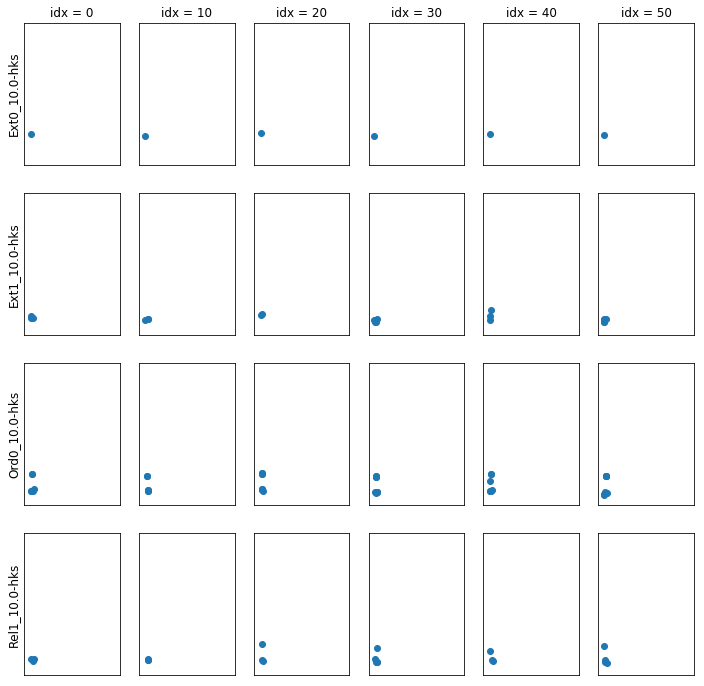

In [6]:
# Run this cell to visualise some example of diagrams generated.
# Requires matplotlib.
visualization(diags_tmp, filts)

Now we preprocess our diagrams to make them PersLay-compatible.

In [7]:
diags = preprocess(diags_tmp, filts)

In [36]:
diags[1][56]

array([[0.46680657, 0.64623223, 1.        ],
       [0.30371392, 0.5962502 , 1.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

# 1bis. Alternative: use your own diagrams

Skip this section if you want to use the diagrams generated above.

TBA.

# 2. Using PersLay in a neural network

We define a PersLay layer, and then a (very simple) neural network architecture that uses PersLay. This can be used as a template to build your own architecture using PersLay.

## 2.1 Set the hyper-parameters

Layer type, must be one of (see [1] for details):
- `"im"` for persistence image layer.
- `"pm"` for permutation equivarient layer (as in [2]).
- `"gs"` for a gaussian layer.
- `"ls"` for a landscape layer.

In [8]:
layer_type = "im"

Permutation invariant operator, must be one of:
- `"sum"`.
- `"topk"`, will select the $k$ highest values, specified in `keep`.

In [9]:
perm_op = "sum"
keep = 5  # only useful if perm_op = "topk"

Weight, must be one of
- `"grid"`, if so, one must pick a grid_size.
- `"linear"`.

In [10]:
weight="grid"
grid_size = [10, 10]  # Only used if weight=="grid"

Now, there are some hyper parameters that are specific to different the layer types.

In [11]:
# Parameter specific to layer_type="im"
image_size=[10, 10]
# Parameter specific to layer_type="gs"
num_gaussians=50
# Parameter specific to layer_type="pm"
d = 50  # Output dimension
# Parameter specific to layer_type="ls"
num_samples = 50

Now we concatenate all these parameters in a dictionnary that will be given to our model (see below).

In [12]:
perslayParameters = {"layer_type":layer_type, 
                     "perm_op": perm_op, "keep":keep, 
                     "weight":weight, "grid_size": grid_size, 
                    "image_size": image_size,
                    "num_gaussians": num_gaussians,
                    "pm_dimension": d,
                    "num_samples": num_samples}

__Note:__ There are some other parameters available to tune PersLay that are not detailed here. This will be updated later. Feel free to check the implementation provided in `archi.py`.

## 2.2 Designing the network

In the template below, we define a very simple `baseModel` that encodes a network architecture. In this model, we define a PersLay layer for each type of diagrams used in input, but all these layers have the same hyper-parameters (as in [1]).

Eventual additional features are simply concatenated with the output of these perslay layers, and a fully connected layer is then used to make the prediction.

In [13]:
model = baseModel(perslayParameters, filts, labels)

## 2.3 Training the network

We can now train our network.

As any neural-network framework, PersLay benefits from the use of GPU(s). If a GPU is available (and `tensorflow-gpu` is installed), the computations should hopefully use it. Otherwise, the computations will be run on the cpu.

### Running the experiments.

We suggest the user to run a single-run first with the `single_run` function, that is training the network once and observing the performance (classification accuracy) on the test set.
- For orbit datasets, the train-test split is 70-30 (to be consistent with [LY18]).
- For graph datasets, the train-test split is 90-10 (to be consistent with [ZWX+18]).

The `single_run` function will load (and print) the network parameters as described in Table 5<CHECK LABEL>: perslay hyperparameters (choice of $\phi$, $w$...), optimizer (number of epochs, learning rate...), etc.
   
It then uses the diagrams (and eventual features) that have been generated when calling `generate(dataset)`, randomly split them into train/test sets, and use them to feed to the network. 

Train and Test accuracies are printed every 10 epochs during the training.

Note that (especially on small datasets like `MUTAG, COX2` etc.), there can be an important variability in the accuracy reported on different calls of `single_run`.

In [14]:
single_run(dataset, model)

Doing a Single Run on the dataset: MUTAG with a 90-10 split.
Filtrations used:
['10.0-hks']
Thresholding in diagrams: 1000
 ***** PersLay parameters: *****
Layer type: im
image size: [20, 20]
grid size: [20, 20]
***** Optimization parameters *****
Optimizer: adam
Number of epochs: 100
Learning rate: 0.01
Decay: 0.9
********************
169 train points and 19 test points
Instructions for updating:
Colocations handled automatically by placer.
current indices
[<tf.Tensor 'tower_0/perslay-0-grid_pweight/Cast:0' shape=(?, 1, 1) dtype=int32>]
Tensor("tower_0/perslay-0-grid_pweight/concat:0", shape=(?, 1, 1), dtype=int32, device=/device:GPU:0)
current W
<tf.Variable 'perslay-0-grid_pweight/W:0' shape=(10, 10) dtype=float32_ref>
current indices
[<tf.Tensor 'tower_0/perslay-0-grid_pweight/Cast:0' shape=(?, 1, 1) dtype=int32>, <tf.Tensor 'tower_0/perslay-0-grid_pweight/Cast_1:0' shape=(?, 1, 1) dtype=int32>]
Tensor("tower_0/perslay-0-grid_pweight/concat_1:0", shape=(?, 1, 2), dtype=int32, devic

InvalidArgumentError: indices[68,0] = [10, 1] does not index into param shape [10,10]
	 [[node tower_0/perslay-0-grid_pweight/GatherNd (defined at /home/theo/Git/perslay/archi.py:77) ]]

Caused by op 'tower_0/perslay-0-grid_pweight/GatherNd', defined at:
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-809927c2500c>", line 1, in <module>
    single_run(dataset, model)
  File "/home/theo/Git/perslay/expe.py", line 400, in single_run
    decay, learn_rate, batch_size, verbose)
  File "/home/theo/Git/perslay/expe.py", line 61, in _evaluate_nn_model
    tow_logit = model.instance(tow_indxs, tow_feats, tow_diags)
  File "/home/theo/Git/perslay/archi.py", line 201, in instance
    peq=[(self.parameters["pm_dimension"], None)]
  File "/home/theo/Git/perslay/archi.py", line 77, in perslay
    weight = tf.expand_dims(tf.gather_nd(params=W, indices=tf.concat(indices, axis=2)), -1)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3647, in gather_nd
    "GatherNd", params=params, indices=indices, name=name)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/theo/anaconda3/envs/tda-deepset/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): indices[68,0] = [10, 1] does not index into param shape [10,10]
	 [[node tower_0/perslay-0-grid_pweight/GatherNd (defined at /home/theo/Git/perslay/archi.py:77) ]]


# Bibliography

[1] _PersLay: A Simple and Versatile Neural Network Layer for Persistence Diagrams._
Mathieu Carrière, Frederic Chazal, Yuichi Ike, Théo Lacombe, Martin Royer, Yuhei Umeda.

[2] _Deep Sets._
Manzil Zaheer, Satwik Kottur, Siamak Ravanbakhsh, Barnabas Poczos, Ruslan R. Salakhutdinov, Alexander J. Smola.
_Advances in Neural Information Processing Systems 30 (NIPS 2017)_